In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torchvision.utils as utils
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

In [7]:
import os
import torch

# Enable CUDA debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize CUDA (if available)
if torch.cuda.is_available():
    torch.cuda.init()
    print("CUDA initialized.")

# Set manual seed
try:
    torch.manual_seed(1)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(1)
    print("Seed set successfully.")
except RuntimeError as e:
    print(f"Error while setting seed: {e}")


Using device: cuda
CUDA initialized.
Seed set successfully.


In [8]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 34769643.15it/s]


Extracting ./dataset/CIFAR10data/cifar-10-python.tar.gz to ./dataset/CIFAR10data


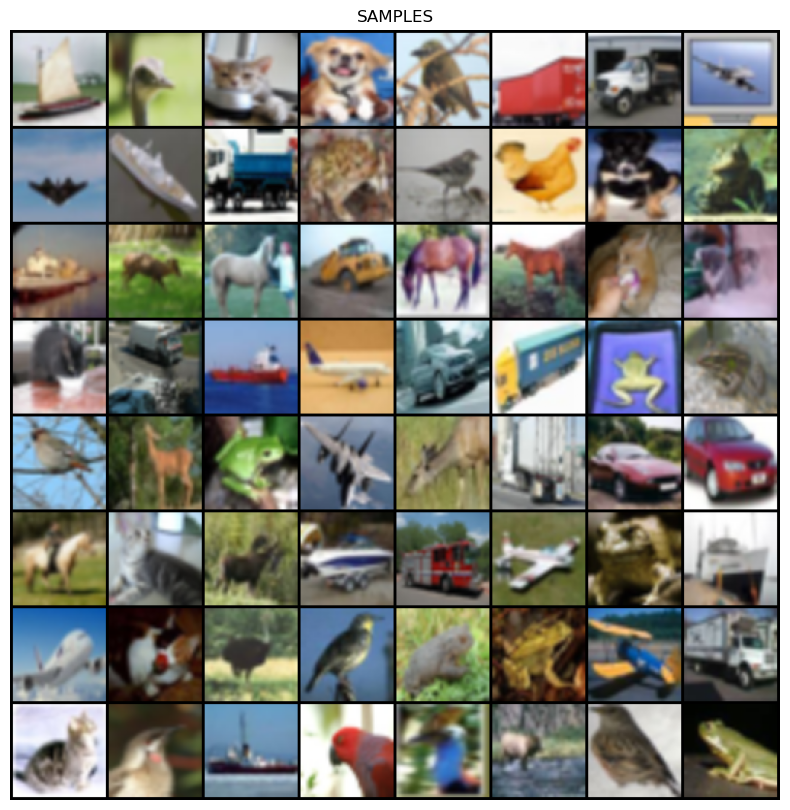

In [9]:
real_batch = next(iter(dataloader))
grid = utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu()
image_data = np.transpose(grid, (1, 2, 0))

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("SAMPLES")
plt.imshow(image_data)


In [11]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size

        # Embedding for class labels
        self.embed = nn.Embedding(num_classes, embed_size)

        # Initial input layer
        self.input_layer = nn.ConvTranspose2d(channels_noise + embed_size, features_g * 16, kernel_size=4, stride=1, padding=0, bias=False)

        # Generator layers
        self.gen1 = self.Gene(features_g * 16, features_g * 8, 4, 2, 1)
        self.gen2 = self.Gene(features_g * 8, features_g * 4, 4, 2, 1)
        self.gen3 = self.Gene(features_g * 4, features_g * 2, 4, 2, 1)

        # Final output layer
        self.output_layer = nn.ConvTranspose2d(
            features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
        )
        self.activation = nn.Tanh()

    def Gene(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, labels):
        # Generate embedding for labels and concatenate with noise input
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)

        # Forward pass through layers
        x = self.input_layer(x)
        x = self.gen1(x)
        x = self.gen2(x)
        x = self.gen3(x)
        x = self.output_layer(x)
        return self.activation(x)


class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        # Embedding for class labels
        self.embed = nn.Embedding(num_classes, img_size * img_size)

        # Initial discriminator layer
        self.input_layer = nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        )
        self.activation1 = nn.LeakyReLU(0.2, inplace=True)

        # Discriminator layers
        self.disc1 = self.Dis(features_d, features_d * 2, 4, 2, 1)
        self.disc2 = self.Dis(features_d * 2, features_d * 4, 4, 2, 1)
        self.disc3 = self.Dis(features_d * 4, features_d * 8, 4, 2, 1)

        # Validity prediction layer
        self.validity_layer = nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)
        self.validity_activation = nn.Sigmoid()

        # Label prediction layer
        self.label_layer = nn.Conv2d(features_d * 8, 11, kernel_size=4, stride=1, padding=0, bias=False)
        self.label_activation = nn.LogSoftmax(dim=1)

    def Dis(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        # Forward pass through layers
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.disc1(x)
        x = self.disc2(x)
        x = self.disc3(x)

        # Validity prediction
        valid = self.validity_layer(x)
        valid = self.validity_activation(valid).view(-1)

        # Label prediction
        label = self.label_layer(x)
        label = self.label_activation(label).view(-1, 11)

        return valid, label


In [12]:
image_size = 64
Channels_img = 3
Noise_input = 100
gen_features = 64
dis_features = 64
NUM_CLASSES = 10
Embed_size = 100

def initialize_weights(model):
    # Use a loop to check each module and initialize weights
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.ConvTranspose2d):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.normal_(module.weight, mean=1.0, std=0.02)
            nn.init.constant_(module.bias, 0)

# Initialize Generator and Discriminator with the provided parameters
gen = Generator(
    num_classes=NUM_CLASSES,
    img_size=image_size,
    embed_size=Embed_size,
    channels_noise=Noise_input,
    channels_img=Channels_img,
    features_g=gen_features,
).to(device)

disc = Discriminator(
    num_classes=NUM_CLASSES,
    img_size=image_size,
    channels_img=Channels_img,
    features_d=dis_features,
).to(device)

# Apply weight initialization
initialize_weights(gen)
initialize_weights(disc)


In [13]:
gen.train() , disc.train()

(Generator(
   (embed): Embedding(10, 100)
   (input_layer): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
   (gen1): Sequential(
     (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (gen2): Sequential(
     (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (gen3): Sequential(
     (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (output_layer): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   (activation): Tanh()
 ),
 

In [14]:
from torchvision import models

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps."""

    # Default block index corresponds to the final average pooling layer
    DEFAULT_BLOCK_INDEX = 3

    # Mapping feature dimensionality to block indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # Features after first max pooling
        192: 1,  # Features after second max pooling
        768: 2,  # Pre-auxiliary classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=None,
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        super(InceptionV3, self).__init__()

        if output_blocks is None:
            output_blocks = [self.DEFAULT_BLOCK_INDEX]

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        if self.last_needed_block > 3:
            raise ValueError("Last possible output block index is 3.")

        self.blocks = self._create_blocks()
        self._set_requires_grad(requires_grad)

    def _create_blocks(self):
        """Helper method to define InceptionV3 blocks."""
        inception = models.inception_v3(pretrained=True)
        blocks = nn.ModuleList()

        # Define Block 0: Input to first max pooling
        block0 = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        blocks.append(block0)

        # Define Block 1: First max pooling to second max pooling
        if self.last_needed_block >= 1:
            block1 = nn.Sequential(
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            )
            blocks.append(block1)

        # Define Block 2: Second max pooling to auxiliary classifier
        if self.last_needed_block >= 2:
            block2 = nn.Sequential(
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e
            )
            blocks.append(block2)

        # Define Block 3: Auxiliary classifier to final average pooling
        if self.last_needed_block >= 3:
            block3 = nn.Sequential(
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            )
            blocks.append(block3)

        return blocks

    def _set_requires_grad(self, requires_grad):
        """Helper method to toggle gradient computation for parameters."""
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outputs = []
        x = inp

        # Resize input if required
        if self.resize_input:
            x = F.interpolate(
                x, size=(299, 299), mode='bilinear', align_corners=False
            )

        # Normalize input if required
        if self.normalize_input:
            x = 2 * x - 1  # Rescale from (0, 1) to (-1, 1)

        # Pass through each block and collect outputs
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
            if idx == self.last_needed_block:
                break

        return outputs


# Instantiate the model with the specified block index
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3(output_blocks=[block_idx])
model = model.cuda()


/home/bsowmya/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bsowmya/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
import numpy as np
from torch.nn.functional import adaptive_avg_pool2d

def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    activations = []
    if cuda:
        images = images.cuda()
    with torch.no_grad():
        preds = model(images)[0]
        if preds.shape[2] != 1 or preds.shape[3] != 1:
            preds = adaptive_avg_pool2d(preds, output_size=(1, 1))
        activations.append(preds.cpu().numpy().reshape(preds.size(0), -1))
    activations = np.concatenate(activations, axis=0)
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)

    return mu, sigma


In [16]:
from scipy import linalg
import numpy as np

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # Ensure inputs are at least 1D or 2D as required
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Check shape compatibility
    if mu1.shape != mu2.shape:
        raise ValueError("Training and test mean vectors have different lengths.")
    if sigma1.shape != sigma2.shape:
        raise ValueError("Training and test covariances have different dimensions.")
    diff = mu1 - mu2
    covmean = None
    try:
        covmean = linalg.sqrtm(sigma1 @ sigma2, disp=False)[0]
        # Handle numerical instability
        if not np.isfinite(covmean).all():
            covmean = None
    except Exception as e:
        print(f"Warning: sqrtm failed due to {str(e)}. Adjusting with epsilon.")

    if covmean is None:
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset) @ (sigma2 + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError(f"Complex values found in covariance matrix: {covmean.imag.max()}")
        covmean = covmean.real
    tr_covmean = np.trace(covmean)

    # Compute the Frechet Distance
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid

def calculate_fretchet(images_real, images_fake, model):
    # Compute activation statistics for real images
    mu1, sigma1 = calculate_activation_statistics(images_real, model, cuda=True)

    mu2, sigma2 = calculate_activation_statistics(images_fake, model, cuda=True)
    fid_value = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_value


In [17]:
fixed_noise = torch.randn(32, Noise_input, 1, 1).to(device)
step = 0

In [18]:
disOptim = optim.Adam(disc.parameters(),6e-5, betas = (0.5,0.999))
genOptim = optim.Adam(gen.parameters(), 6e-5, betas = (0.5,0.999))
criterion = nn.BCELoss()
counter = 0
img_list = []
GenLoss = []
DiscLoss = []
iters = 0
FID_list = []
MAX_EPOCHS = 40

In [19]:
for epoch in range(1, MAX_EPOCHS + 1):  # Start epoch count from 1
    for batch_idx, (realImg, labels) in enumerate(dataloader):
        # Move data to device
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.size(0)
        fakeClassLabel = 10 * torch.ones((miniBatch,), dtype=torch.long).to(device)
        disc.zero_grad()
        real_label = torch.ones((miniBatch,), dtype=torch.float).to(device)
        disc_real, disc_label = disc(real)
        real_loss_value = criterion(disc_real, real_label)
        real_label_loss = F.nll_loss(disc_label, labels)
        real_loss_disc = real_loss_value + real_label_loss
        real_loss_disc.backward()
        noise = torch.randn(miniBatch, Noise_input, 1, 1).to(device)
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype=torch.long).to(device)
        fake = gen(noise, sampleLabel)
        fake_label = torch.zeros((miniBatch,), dtype=torch.float).to(device)
        disc_fake, disc_fLabel = disc(fake.detach())
        fake_loss_value = criterion(disc_fake, fake_label)
        fake_label_loss = F.nll_loss(disc_fLabel, fakeClassLabel)
        fake_loss_disc = fake_loss_value + fake_label_loss
        fake_loss_disc.backward()
        loss_disc = (real_loss_disc + fake_loss_disc) / 2
        disOptim.step()
        gen.zero_grad()

        # Generate fake images
        noise = torch.randn(miniBatch, Noise_input, 1, 1).to(device)
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype=torch.long).to(device)
        fake = gen(noise, sampleLabel)

        # Generator loss
        real_label.fill_(1.0)  # Target real labels for generator
        gen_output, gen_output_label = disc(fake)
        gen_loss_value = criterion(gen_output, real_label)
        gen_label_loss = F.nll_loss(gen_output_label, sampleLabel)
        loss_gen = gen_loss_value + gen_label_loss
        loss_gen.backward()
        genOptim.step()
        # Record losses
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())

        # Save generated images for visualization
        if (iters % 500 == 0) or ((epoch == MAX_EPOCHS) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gen(noise, sampleLabel).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    with torch.no_grad():
        fretchet_dist = calculate_fretchet(real, fake, model)
        FID_list.append(fretchet_dist)
    print(
        f"Epoch [{epoch}/{MAX_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
        f"discriminator loss: {loss_disc:.3f}, generator loss: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f}"
    )

    # Generate final set of images for the epoch
    images = gen(noise, sampleLabel).detach()


Epoch [1/40] Batch 781/782 discriminator loss: 2.251, generator loss: 2.685, FID Score: 467.072
Epoch [2/40] Batch 781/782 discriminator loss: 2.198, generator loss: 2.245, FID Score: 391.107
Epoch [3/40] Batch 781/782 discriminator loss: 2.014, generator loss: 2.018, FID Score: 368.532
Epoch [4/40] Batch 781/782 discriminator loss: 2.000, generator loss: 2.089, FID Score: 366.750
Epoch [5/40] Batch 781/782 discriminator loss: 2.141, generator loss: 3.074, FID Score: 358.276
Epoch [6/40] Batch 781/782 discriminator loss: 2.273, generator loss: 2.153, FID Score: 350.247
Epoch [7/40] Batch 781/782 discriminator loss: 1.680, generator loss: 2.896, FID Score: 336.203
Epoch [8/40] Batch 781/782 discriminator loss: 1.504, generator loss: 2.985, FID Score: 309.433
Epoch [9/40] Batch 781/782 discriminator loss: 1.747, generator loss: 2.689, FID Score: 311.143
Epoch [10/40] Batch 781/782 discriminator loss: 1.587, generator loss: 2.559, FID Score: 321.594
Epoch [11/40] Batch 781/782 discriminat

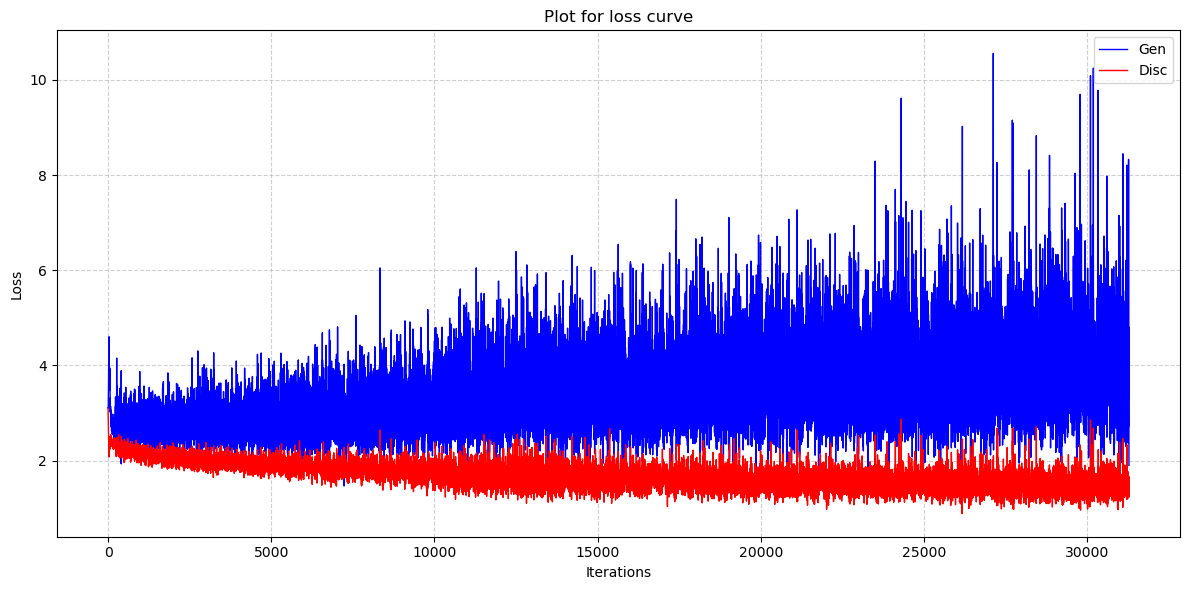

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot for loss curves
plt.figure(figsize=(12, 6))  
plt.title("Plot for loss curve")
plt.plot(GenLoss, label="Gen", color="blue", linewidth=1.0)  
plt.plot(DiscLoss, label="Disc", color="red", linewidth=1.0)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc="upper right")  
plt.grid(True, linestyle='--', alpha=0.6)  
plt.tight_layout()  
plt.show()


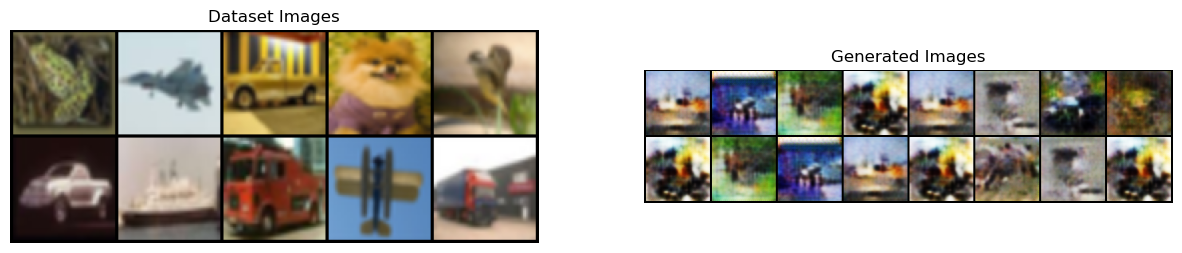

In [23]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Dataset Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


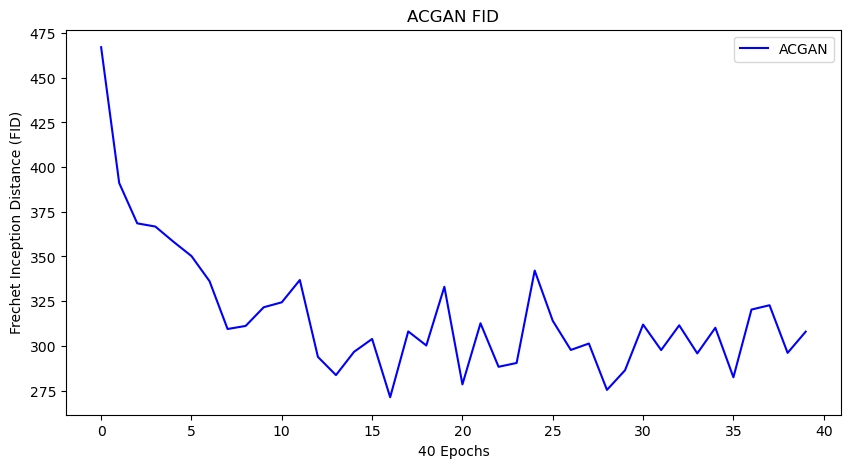

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("ACGAN FID")
ax.set_xlabel("40 Epochs")
ax.set_ylabel("Frechet Inception Distance (FID)")
ax.plot(FID_list, label="ACGAN", color="blue", linewidth=1.5)
ax.legend()
plt.show()
